In [45]:
import sys
import os # my addtion

import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.data
import torch
import cebra.integrations
import cebra.datasets
from cebra import CEBRA
import torch
import pickle
import cebra_pack.utils as cp
import seaborn as sns
import re

from matplotlib.collections import LineCollection
import pandas as pd

## QUICK SESSION STATS ANALYSIS

In [46]:
df_all_choice = pickle.load(open("/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/stats_files/all_session_stats_choice.pkl", "rb"))

In [47]:
df_all_choice

,subject_ID,ses_idx,all4_AUC_choice,DA_AUC_choice,NE_AUC_choice,5HT_AUC_choice,ACh_AUC_choice,b4_AUC_choice,af_AUC_choice,ses_idx_count
0,634704,634704_2022-08-31,0.998162,0.953547,0.975854,0.975771,0.940264,0.975688,0.988971,1
1,632110,632110_2022-08-10,1.000000,0.921269,0.961124,0.869761,0.953878,0.964747,0.954759,1
2,632106,632106_2022-10-28,0.500000,0.795429,0.908646,0.889115,0.807967,0.953383,0.917931,1
3,634704,634704_2022-09-01,0.995392,0.926250,0.974654,0.500000,0.959252,0.930858,0.983853,2
4,632110,632110_2022-08-11,0.991597,0.933757,0.917934,0.882247,0.978938,0.960004,0.976864,2
...,...,...,...,...,...,...,...,...,...,...
206,632106,632106_2022-10-20,0.952741,0.500000,0.721097,0.656238,0.732648,0.847366,0.874548,12
207,632106,632106_2022-10-24,0.983246,0.846930,0.914934,0.500000,0.843591,0.848845,0.923093,13
208,632106,632106_2022-10-25,0.975169,0.718124,0.866027,0.828422,0.500000,0.861373,0.578131,14
209,632106,632106_2022-10-21,0.945950,0.500000,0.763561,0.828547,0.816209,0.879587,0.907429,15


In [48]:
def plot_score_ind_nms(df, score='AUC', title='Mean scores across 211 sessions of Embeddings of Individual NMs'):

    all_auc_mean = df.loc[:,df.columns[df.columns.str.contains('^(all4)', regex=True)]].mean()[0]
    ind_nms_mean_auc = np.array(df.loc[:,df.columns[df.columns.str.contains('^(DA|NE|5HT|ACh)', regex=True)]].mean())

    b4_auc_mean = df.loc[:,df.columns[df.columns.str.contains('^(b4)', regex=True)]].mean()
    af_auc_mean = df.loc[:,df.columns[df.columns.str.contains('^(b4)', regex=True)]].mean()

    sns.stripplot(data=df.loc[:,df.columns[df.columns.str.contains('^(DA|NE|5HT|ACh)', regex=True)]])
    plt.plot(ind_nms_mean_auc, 'ko', label=f'individual mean {score} score')
    plt.xlabel('Neuromodulator')
    plt.axhline(np.round(all_auc_mean,2), linestyle='--', c='k',label='combined dataset mean (All 4)')
    plt.ylabel(f'{score} Score')
    plt.title(title)
    plt.legend()
    plt.show()

    return all_auc_mean
    # %%

/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipykernel_47356/2301636678.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  all_auc_mean = df.loc[:,df.columns[df.columns.str.contains('^(all4)', regex=True)]].mean()[0]
/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipykernel_47356/2301636678.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ind_nms_mean_auc = np.array(df.loc[:,df.columns[df.columns.str.contains('^(DA|NE|5HT|ACh)', regex=True)]].mean())
/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipykernel_47356/2301636678.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  b4_auc_mean = df.loc[:,df.columns[df.columns.str.contains('^(b4)', regex=True)]].mean()
/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipyk

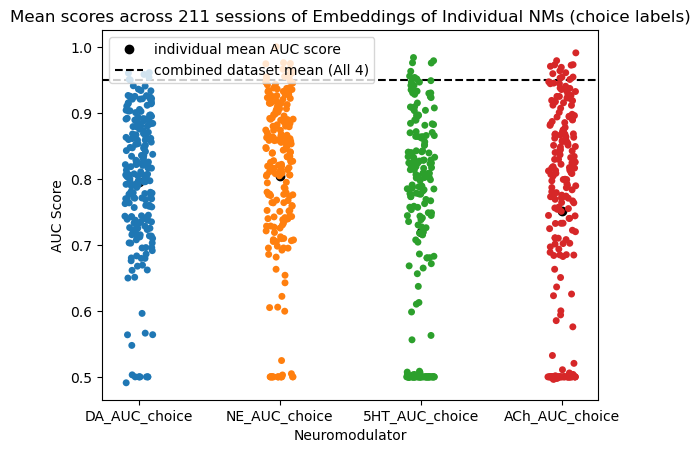

In [49]:
all_auc_mean = plot_score_ind_nms(df_all_choice, title='Mean scores across 211 sessions of Embeddings of Individual NMs (choice labels)')

In [50]:
df_all_reward = pickle.load(open("/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/stats_files/all_session_stats.pkl", "rb"))

In [51]:
df_all_reward

,subject_ID,ses_idx,all4_AUC,DA_AUC,NE_AUC,5HT_AUC,ACh_AUC,b4_AUC,af_AUC,ses_idx_count
0,632104,632104_2022-07-27,0.992895,0.981000,0.983636,0.846397,0.903878,0.901884,0.995210,1
1,632104,632104_2022-08-09,0.995206,0.987634,0.991667,0.874597,0.939695,0.869041,0.995206,2
2,632104,632104_2022-07-22,0.998305,0.965993,0.985014,0.824341,0.898355,0.899136,0.995830,3
3,632104,632104_2022-08-03,0.992652,0.933692,0.961290,0.806093,0.852599,0.839695,0.985305,4
4,632104,632104_2022-07-26,0.990683,0.985139,0.946766,0.824784,0.892213,0.938343,0.982033,5
...,...,...,...,...,...,...,...,...,...,...
206,632106,632106_2022-10-26,0.998529,0.969857,0.973164,0.879073,0.819647,0.873684,0.987870,12
207,632106,632106_2022-10-19,0.996454,0.975261,0.954715,0.908556,0.852717,0.834507,0.992345,13
208,632106,632106_2022-08-26,0.997788,0.973262,0.987211,0.850639,0.793034,0.813127,0.995960,14
209,632106,632106_2022-10-25,0.997229,0.977488,0.959089,0.892157,0.781093,0.842502,0.993701,15


/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipykernel_47356/2301636678.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  all_auc_mean = df.loc[:,df.columns[df.columns.str.contains('^(all4)', regex=True)]].mean()[0]
/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipykernel_47356/2301636678.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ind_nms_mean_auc = np.array(df.loc[:,df.columns[df.columns.str.contains('^(DA|NE|5HT|ACh)', regex=True)]].mean())
/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipykernel_47356/2301636678.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  b4_auc_mean = df.loc[:,df.columns[df.columns.str.contains('^(b4)', regex=True)]].mean()
/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipyk

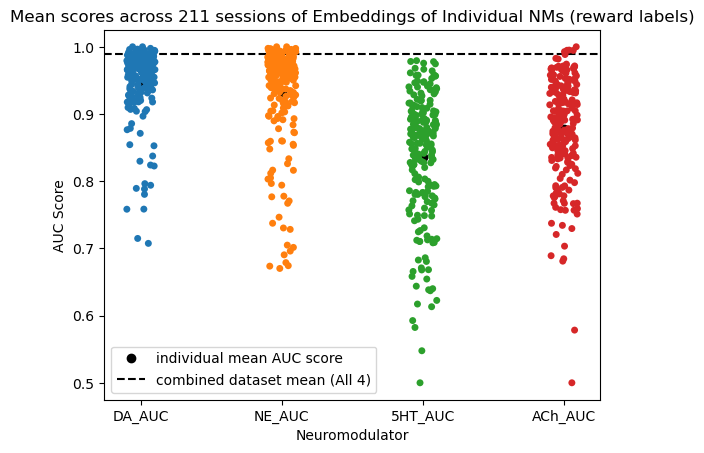

In [52]:
all_auc_mean_reward = plot_score_ind_nms(df_all_reward,title='Mean scores across 211 sessions of Embeddings of Individual NMs (reward labels)')

In [53]:
df_all_rpe = pickle.load(open("/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/stats_files/all_session_stats(rpe).pkl", "rb"))

In [54]:
df_all_rpe

,subject_ID,ses_idx,all4_R2_rpe,DA_R2_rpe,NE_R2_rpe,5HT_R2_rpe,ACh_R2_rpe,b4_R2_rpe,af_R2_rpe,ses_idx_count
0,631199,631199_2022-07-12,0.791241,0.219024,0.188226,0.155231,0.337028,0.254467,0.587477,1
1,631198,631198_2022-07-20,0.685341,0.048660,0.032319,0.143145,0.143190,0.120334,0.556137,1
2,631198,631198_2022-07-22,0.767858,0.167233,0.080518,0.079767,0.046843,0.176723,0.612808,2
3,631198,631198_2022-07-14,0.773498,0.112886,0.041683,0.175115,0.078205,0.112344,0.642634,3
4,631198,631198_2022-07-21,0.746688,0.055202,0.013265,0.098098,0.242081,0.069547,0.605273,4
...,...,...,...,...,...,...,...,...,...,...
192,632105,632105_2022-09-30,0.676871,0.483525,0.399667,0.344909,0.374535,0.095307,0.503883,20
193,632106,632106_2022-08-08,0.481863,0.590512,0.593080,0.003634,0.005350,0.015519,0.516575,16
194,632105,632105_2022-10-07,0.796919,0.666115,0.710019,0.598526,0.393595,0.536638,0.741183,21
195,632105,632105_2022-10-10,0.252058,0.319050,0.280959,0.016300,0.130194,0.057407,0.205339,22


/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipykernel_47356/2301636678.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  all_auc_mean = df.loc[:,df.columns[df.columns.str.contains('^(all4)', regex=True)]].mean()[0]
/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipykernel_47356/2301636678.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ind_nms_mean_auc = np.array(df.loc[:,df.columns[df.columns.str.contains('^(DA|NE|5HT|ACh)', regex=True)]].mean())
/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipykernel_47356/2301636678.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  b4_auc_mean = df.loc[:,df.columns[df.columns.str.contains('^(b4)', regex=True)]].mean()
/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipyk

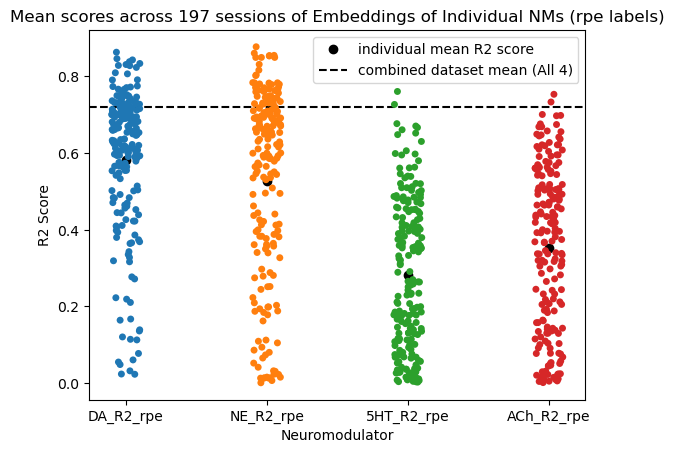

In [55]:
all_rpe_scores = plot_score_ind_nms(df_all_rpe,score='R2', title='Mean scores across 197 sessions of Embeddings of Individual NMs (rpe labels)')

In [56]:
df_all_reward_sorted = df_all_reward.sort_values(by='ses_idx').reset_index(drop=True)

In [57]:
df_all_reward_sorted.head()

,subject_ID,ses_idx,all4_AUC,DA_AUC,NE_AUC,5HT_AUC,ACh_AUC,b4_AUC,af_AUC,ses_idx_count
0,631198,631198_2022-07-13,0.992727,0.758430,0.826033,0.838678,0.761074,0.846446,0.971240,3
1,631198,631198_2022-07-14,0.991778,0.780381,0.777674,0.785795,0.786765,0.852440,0.946557,5
2,631198,631198_2022-07-20,0.995918,0.714789,0.776727,0.756469,0.797861,0.811270,0.952198,2
3,631198,631198_2022-07-21,0.994636,0.707457,0.794087,0.712114,0.781502,0.800157,0.954003,6
4,631198,631198_2022-07-22,0.993845,0.793938,0.803110,0.710359,0.720706,0.840023,0.958880,4


In [58]:
df_all_choice_sorted = df_all_choice.sort_values(by='ses_idx').reset_index(drop=True)

In [59]:
df_all_choice_sorted.head()

,subject_ID,ses_idx,all4_AUC_choice,DA_AUC_choice,NE_AUC_choice,5HT_AUC_choice,ACh_AUC_choice,b4_AUC_choice,af_AUC_choice,ses_idx_count
0,631198,631198_2022-07-13,0.985814,0.847536,0.752096,0.893606,0.906947,0.934125,0.968115,1
1,631198,631198_2022-07-14,0.982619,0.888621,0.599481,0.955530,0.935230,0.924452,0.968345,5
2,631198,631198_2022-07-20,0.996297,0.835301,0.776938,0.946463,0.932702,0.949688,0.969326,4
3,631198,631198_2022-07-21,0.989858,0.911413,0.500000,0.946659,0.954169,0.932022,0.981963,2
4,631198,631198_2022-07-22,0.992369,0.905078,0.811985,0.975445,0.972123,0.938781,0.986061,3


In [60]:
df_all_choice_sorted['ses_idx'][58]

'632105_2022-08-17'

In [61]:
df_all_reward_sorted['ses_idx'][58]

'632105_2022-08-17'

In [62]:
merged1 = pd.merge(df_all_choice_sorted,df_all_reward_sorted, on =['subject_ID', 'ses_idx'])
merged1

,subject_ID,ses_idx,all4_AUC_choice,DA_AUC_choice,NE_AUC_choice,5HT_AUC_choice,ACh_AUC_choice,b4_AUC_choice,af_AUC_choice,ses_idx_count_x,all4_AUC,DA_AUC,NE_AUC,5HT_AUC,ACh_AUC,b4_AUC,af_AUC,ses_idx_count_y
0,631198,631198_2022-07-13,0.985814,0.847536,0.752096,0.893606,0.906947,0.934125,0.968115,1,0.992727,0.758430,0.826033,0.838678,0.761074,0.846446,0.971240,3
1,631198,631198_2022-07-14,0.982619,0.888621,0.599481,0.955530,0.935230,0.924452,0.968345,5,0.991778,0.780381,0.777674,0.785795,0.786765,0.852440,0.946557,5
2,631198,631198_2022-07-20,0.996297,0.835301,0.776938,0.946463,0.932702,0.949688,0.969326,4,0.995918,0.714789,0.776727,0.756469,0.797861,0.811270,0.952198,2
3,631198,631198_2022-07-21,0.989858,0.911413,0.500000,0.946659,0.954169,0.932022,0.981963,2,0.994636,0.707457,0.794087,0.712114,0.781502,0.800157,0.954003,6
4,631198,631198_2022-07-22,0.992369,0.905078,0.811985,0.975445,0.972123,0.938781,0.986061,3,0.993845,0.793938,0.803110,0.710359,0.720706,0.840023,0.958880,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,641494,641494_2022-11-07,0.990626,0.842717,0.926139,0.777477,0.882658,0.836582,0.960849,8,0.971844,0.822588,0.695974,0.592584,0.729510,0.747444,0.882308,13
207,641494,641494_2022-11-08,0.969019,0.803670,0.864689,0.500000,0.853691,0.923261,0.930889,12,0.968991,0.837445,0.746422,0.613162,0.737349,0.717541,0.904845,12
208,641494,641494_2022-11-09,0.985047,0.902144,0.931592,0.500000,0.503684,0.891876,0.965951,6,0.927228,0.789301,0.678821,0.582310,0.681014,0.627279,0.845808,11
209,641494,641494_2022-11-10,0.964527,0.819538,0.890390,0.768769,0.799362,0.904584,0.939494,13,0.981889,0.871179,0.704854,0.668246,0.756769,0.737957,0.928511,14


In [63]:
df_all_rpe_sorted = df_all_rpe.sort_values(by='ses_idx').reset_index(drop=True)

In [64]:
merged2 = pd.merge(merged1, df_all_rpe_sorted, on=['ses_idx', 'subject_ID'], how='outer')

In [65]:
merged2

,subject_ID,ses_idx,all4_AUC_choice,DA_AUC_choice,NE_AUC_choice,5HT_AUC_choice,ACh_AUC_choice,b4_AUC_choice,af_AUC_choice,ses_idx_count_x,...,af_AUC,ses_idx_count_y,all4_R2_rpe,DA_R2_rpe,NE_R2_rpe,5HT_R2_rpe,ACh_R2_rpe,b4_R2_rpe,af_R2_rpe,ses_idx_count
0,631198,631198_2022-07-13,0.985814,0.847536,0.752096,0.893606,0.906947,0.934125,0.968115,1,...,0.971240,3,0.759791,0.032237,0.015745,0.331895,0.120686,0.195630,0.657871,6.0
1,631198,631198_2022-07-14,0.982619,0.888621,0.599481,0.955530,0.935230,0.924452,0.968345,5,...,0.946557,5,0.773498,0.112886,0.041683,0.175115,0.078205,0.112344,0.642634,3.0
2,631198,631198_2022-07-20,0.996297,0.835301,0.776938,0.946463,0.932702,0.949688,0.969326,4,...,0.952198,2,0.685341,0.048660,0.032319,0.143145,0.143190,0.120334,0.556137,1.0
3,631198,631198_2022-07-21,0.989858,0.911413,0.500000,0.946659,0.954169,0.932022,0.981963,2,...,0.954003,6,0.746688,0.055202,0.013265,0.098098,0.242081,0.069547,0.605273,4.0
4,631198,631198_2022-07-22,0.992369,0.905078,0.811985,0.975445,0.972123,0.938781,0.986061,3,...,0.958880,4,0.767858,0.167233,0.080518,0.079767,0.046843,0.176723,0.612808,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,641494,641494_2022-11-07,0.990626,0.842717,0.926139,0.777477,0.882658,0.836582,0.960849,8,...,0.882308,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
207,641494,641494_2022-11-08,0.969019,0.803670,0.864689,0.500000,0.853691,0.923261,0.930889,12,...,0.904845,12,0.526098,0.271763,0.065649,0.011270,0.076176,0.135489,0.440902,7.0
208,641494,641494_2022-11-09,0.985047,0.902144,0.931592,0.500000,0.503684,0.891876,0.965951,6,...,0.845808,11,0.120070,0.023948,0.022923,0.010527,0.019635,0.003824,0.114538,9.0
209,641494,641494_2022-11-10,0.964527,0.819538,0.890390,0.768769,0.799362,0.904584,0.939494,13,...,0.928511,14,0.476329,0.461247,0.073807,0.135362,0.134853,0.139161,0.477316,10.0
